
# 项目：未前往就诊的挂号预约

## 目录
<ul>
<li><a href="#intro">简介</a></li>
<li><a href="#wrangling">数据整理</a></li>
<li><a href="#eda">探索性数据分析</a></li>
<li><a href="#conclusions">结论</a></li>
</ul>

<a id='intro'></a>
## 简介

>  本数据集包含10万条巴西预约挂号的求诊信息，研究病人是否如约前往医院就诊。每行数据录入了有关患者特点的多个数值，包括 “预约日期 (ScheduledDay)”指患者具体预约就诊的日期；“街区 (Neighborhood) ”指医院所在位置；“福利保障 (Scholarship)”说明病人是否是巴西福利项目 Bolsa Família 的保障人群；最后一列内容的编码：“No”表示病人已如约就诊，“Yes”说明病人未前往就诊。
通过对数据集数据的分析和研究找出与预约未就诊的相关因素，并对病人预约未能就诊作出预判，同时也能了解到巴西公共卫生系统的情况。    
研究问题：
<ul>
<li><a href="#quest1">预约与就诊时间相隔时间</a></li>
<li><a href="#quest2">失约人失约次数</a></li>
<li><a href="#quest3">不同地区的失约情况</a></li>
<li><a href="#quest4">病历登记各项记录对失约情况影响</a></li>
</ul>

In [75]:
# 用这个框对你计划使用的所有数据包设置
#   导入语句。
import os
import sys
import pandas as pd
import numpy as np
import time,datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<a id='wrangling'></a>
## 数据整理

### 常规属性

In [76]:
# 加载数据并打印几行。进行几项操作，检查数据
#   类型，以及是否有缺失数据或错误数据。
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.990000e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.590000e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.260000e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.680000e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.840000e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [77]:
#检查数据类型
df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

In [78]:
#检查是否有缺失值
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [79]:
#描述信息
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474961e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560943e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.920000e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.170000e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.170000e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.440000e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000e+15,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [80]:
#男女预约人数
df['Gender'].value_counts()

F    71840
M    38687
Name: Gender, dtype: int64

In [81]:
#失约与未失约人数
df.groupby(['Gender'])['No-show'].value_counts()

Gender  No-show
F       No         57246
        Yes        14594
M       No         30962
        Yes         7725
Name: No-show, dtype: int64



### 未前往就诊的挂号预约数据清理

> **数据整理**：1.去重
2.将列名No-show改为No_show
3.筛选出挂号后未前来就诊的患者


In [82]:
# 讨论数据结构和需要解决的任何问题之后，
#   在本段的第二部分进行这些清理步骤。
df = df.drop_duplicates()

In [83]:
#更改列名
df.rename(columns = lambda x:x.strip().replace('-','_'),inplace =True)

In [84]:
#查找预约未就诊的
df_m = df.query('No_show == "Yes"')

In [85]:
df_m.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show
6,7.340000e+14,5630279,F,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,GOIABEIRAS,0,0,0,0,0,0,Yes
7,3.450000e+12,5630575,F,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,GOIABEIRAS,0,0,0,0,0,0,Yes
11,7.540000e+12,5620163,M,2016-04-26T08:44:12Z,2016-04-29T00:00:00Z,29,NOVA PALESTINA,0,0,0,0,0,1,Yes
17,1.480000e+13,5633460,F,2016-04-28T09:28:57Z,2016-04-29T00:00:00Z,40,CONQUISTA,1,0,0,0,0,0,Yes
20,6.220000e+14,5626083,F,2016-04-27T07:51:14Z,2016-04-29T00:00:00Z,30,NOVA PALESTINA,0,0,0,0,0,0,Yes


In [86]:
type(df_m['ScheduledDay'][6])

str

In [87]:
def df_column_normalize(dataframe, percent=False):
    # “格式化        如果%=True，则将最终值乘以100。
    # https://stackoverflow.com/questions/26537878/pandas-sum-across-columns-and-divide-each-cell-from-that-value
    if percent:
        return dataframe.div(dataframe.sum(axis=0), axis=1)*100
    else:
        return dataframe.div(dataframe.sum(axis=0), axis=1)

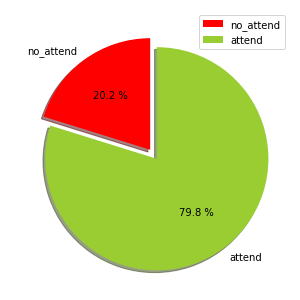

In [88]:
#绘制按约就诊和未就诊比例的饼状图
labels = ['no_attend', 'attend']
plt.figure(figsize=(5,8))
no_attend_rate=df_m['No_show'].count()*100.0/df['No_show'].count() # 失约比例
attend_rate = 100 - no_attend_rate #按约比例
fracs = [no_attend_rate,attend_rate]
explode = [0, 0.1] # 0.1 凸出这部分，
colors = ['red','yellowgreen']
plt.axes(aspect=1)  # set this , Figure is round, otherwise it is an ellipse
#autopct ，show percet
plt.pie(x=fracs, labels=labels, explode=explode,autopct='%3.1f %%',colors = colors,
        shadow=True, labeldistance=1.1, startangle = 90,pctdistance = 0.6
        );
plt.legend(loc = 'upper right')
plt.show()

In [89]:
labels = ['attend', 'no_attend']
df_attend = df_m
df['attend_rate'] = df_m.count()/df.count()




In [90]:
#将字符串转换成日期
df['ScheduledDay'] = pd.to_datetime(df.ScheduledDay)
df['AppointmentDay'] = pd.to_datetime(df.AppointmentDay)
#创建新的列
df['ScheduleTime'] = df.ScheduledDay.dt.time
#格式化就诊时间
df['ScheduledDay'] = df.ScheduledDay.dt.normalize()


In [91]:
#添加一列预约时间和就诊时间的时间差
df['WaitingDays'] = df['AppointmentDay'] - df['ScheduledDay']
#找出预约时间滞后于就诊时间的情况
df[df['WaitingDays'] < pd.tslib.Timedelta('0 days')]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show,attend_rate,ScheduleTime,WaitingDays
27033,7.840000e+12,5679978,M,2016-05-10,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,Yes,NaN,10:51:53,-1 days
55226,7.900000e+12,5715660,F,2016-05-18,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,Yes,NaN,14:50:41,-1 days
64175,2.430000e+13,5664962,F,2016-05-05,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,Yes,NaN,13:43:58,-1 days
71533,9.980000e+14,5686628,F,2016-05-11,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes,NaN,13:49:20,-6 days
72362,3.790000e+12,5655637,M,2016-05-04,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,Yes,NaN,06:50:57,-1 days


In [92]:
#去除错误数据
error_index = df[df['WaitingDays'] < pd.tslib.Timedelta('0 days')].index
df.drop(error_index, inplace=True)

In [93]:
#df['WaitingDays'].value_counts()
#df['WaitingDays'].value_counts()
#.plot(kind = 'bar',figsize = (22,16))
df['WaitingDays'] = df.WaitingDays.dt.days

In [94]:
waitingdays = df.groupby(by=['WaitingDays','No_show'])

In [95]:
#将数据行列转置
waitingdays = waitingdays.count()['PatientId'].unstack()

In [96]:
#将数据中空值填充为0
waitingdays.fillna(0,inplace=True)


In [97]:
waitingdays.reset_index(drop=False, inplace=True)
waitingdays.shape

(129, 3)

<a id='eda'></a>
## 探索性数据分析

<a id='quest1'></a>

### 1、预约与就诊时间相隔时间

#### 处理
>到这里数据基本处理完毕，但是由于预约和就诊之间间隔天数的跨度相对较长，从上述维度可以看出有129个不同的天数间隔，因此需要天数进行划分，判断不同区间的间隔天数失约人数和失约就诊率

In [98]:
categories = pd.Series(['Same day: 0', 'Short: 1-3', 'Week: 4-7', 'Fortnight: 8-15', 'Month: 16-30', 'Quarter: 31-90', 'Semester: 91-180', 'Very long: >180'])

In [99]:
waitingdays['WaitingDays'] = pd.cut(waitingdays.WaitingDays, bins = [-1,0,3,7,15,30,90,180, 10000], labels=categories)
df['WaitingCategories'] = pd.cut(df.WaitingDays, bins = [-1,0,3,7,15,30,90,180, 10000], labels=categories)

In [100]:
## Grouping the dataset by the waiting categories, returning the sum of all instances:
waitingdays = waitingdays.groupby('WaitingDays').sum()
## Creating a new attribute, "No-showing rate", relating how many patients did not show up against those who did.
waitingdays['No-showing rate'] = (waitingdays.Yes / waitingdays.No)*100

In [101]:
## Viewing the resulting dataset:
waitingdays

No_show,No,Yes,No-showing rate
WaitingDays,,,
Same day: 0,36771.0,1792.0,4.873406
Short: 1-3,11316.0,3359.0,29.683634
Week: 4-7,13097.0,4413.0,33.694739
Fortnight: 8-15,9362.0,4166.0,44.499039
Month: 16-30,10709.0,5159.0,48.174433
Quarter: 31-90,6792.0,3369.0,49.602473
Semester: 91-180,161.0,56.0,34.782609
Very long: >180,NaN,NaN,NaN


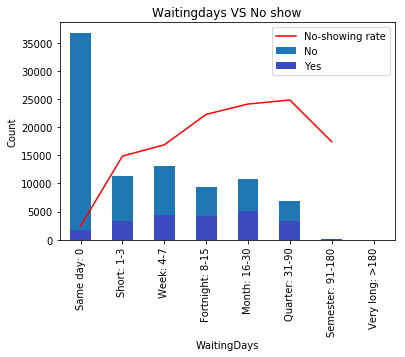

In [102]:
"""
#绘制图表显示
X = np.arange(8)+1
No_come = waitingdays['Yes']
Yes_come = waitingdays['No']
rate = waitingdays['No-showing rate']
labels = ['Same day', 'Short','Week','Fortnight','Month','Quarter','Semester','Very long']
plt.bar(X,Yes_come,width = 0.35,facecolor = 'lightskyblue',edgecolor = 'white',label = "No");
#width:柱的宽度
plt.bar(X+0.35,No_come,width = 0.35,facecolor = 'yellowgreen',edgecolor = 'white',label = "Yes");
plt.plot(X,rate*500,'r');
plt.legend();
"""
X = np.arange(8)+1
waitingdays['No'].plot(kind = 'bar',stacked = 'True')
waitingdays['Yes'].plot(kind = 'bar',stacked = 'True',colormap  = 'coolwarm')
plt.ylabel('Count')
plt.plot(X-1,waitingdays['No-showing rate']*500,'r')
plt.title('Waitingdays VS No show')
plt.legend();


### 分析
>人们可能会忘记预约，因为等待时间越长，no-showing 就越明显。正如图表中的红线所显示的那样，当出现在同一天的出勤情况时，无显示率就会达到较低的值。我们可以把它与急救护理联系起来，甚至是病人在没有事先安排的情况下去卫生部门。
然而，在一个季度的等待之后，病人的预约就诊情况有所好转，而no-showing从49.6%下降到34.78。老年人以及患有慢性疾病需要定期医疗随访倾向于长期安排约会和参加。


<a id='quest2'></a>

### 2、失约人失约次数和概率


In [103]:
# 继续探索数据，解决你的附加研究问题。
#   如果有其它问题要调查，
#   请根据需要添加更多标题。
dfgb = df.groupby(['PatientId'])
df_stack = dfgb['No_show'].value_counts().unstack().fillna(0.)
df_stack['rate'] = df_stack['Yes'] /(df_stack['No'] + df_stack['Yes'])
df_stack_rate = df_stack.query('rate>0.5')
df_stack_rate.query('Yes > 5')

No_show,No,Yes,rate
PatientId,,,
2.851680e+10,0.0,7.0,1.000000
5.472764e+10,2.0,6.0,0.750000
8.279122e+10,1.0,6.0,0.857143
9.717348e+10,0.0,6.0,1.000000
3.650000e+11,5.0,13.0,0.722222
3.810000e+11,4.0,7.0,0.636364
4.770000e+11,10.0,13.0,0.565217
6.310000e+11,8.0,10.0,0.555556
9.720000e+11,6.0,7.0,0.538462


###  分析
>筛选出未就诊概率大于50%,预约次数大于5次的患者，说明该患者在接下来的预约中会有大概率的失约可能

<a id='quest3'></a>

### 3、不同地区的失约情况


>对不同地区的失约情况进行统计，判断哪些地区的失约较为严重

In [104]:
## 获取不同地区的名字
neighborhood = df.Neighbourhood.unique()
neighborhood.sort()  #排序
neighborhood  

array(['AEROPORTO', 'ANDORINHAS', 'ANTÔNIO HONÓRIO', 'ARIOVALDO FAVALESSA',
       'BARRO VERMELHO', 'BELA VISTA', 'BENTO FERREIRA', 'BOA VISTA',
       'BONFIM', 'CARATOÍRA', 'CENTRO', 'COMDUSA', 'CONQUISTA',
       'CONSOLAÇÃO', 'CRUZAMENTO', 'DA PENHA', 'DE LOURDES', 'DO CABRAL',
       'DO MOSCOSO', 'DO QUADRO', 'ENSEADA DO SUÁ', 'ESTRELINHA',
       'FONTE GRANDE', 'FORTE SÃO JOÃO', 'FRADINHOS', 'GOIABEIRAS',
       'GRANDE VITÓRIA', 'GURIGICA', 'HORTO', 'ILHA DAS CAIEIRAS',
       'ILHA DE SANTA MARIA', 'ILHA DO BOI', 'ILHA DO FRADE',
       'ILHA DO PRÍNCIPE', 'ILHAS OCEÂNICAS DE TRINDADE', 'INHANGUETÁ',
       'ITARARÉ', 'JABOUR', 'JARDIM CAMBURI', 'JARDIM DA PENHA',
       'JESUS DE NAZARETH', 'JOANA D´ARC', 'JUCUTUQUARA', 'MARIA ORTIZ',
       'MARUÍPE', 'MATA DA PRAIA', 'MONTE BELO', 'MORADA DE CAMBURI',
       'MÁRIO CYPRESTE', 'NAZARETH', 'NOVA PALESTINA', 'PARQUE INDUSTRIAL',
       'PARQUE MOSCOSO', 'PIEDADE', 'PONTAL DE CAMBURI', 'PRAIA DO CANTO',
       'PRAIA DO SUÁ',

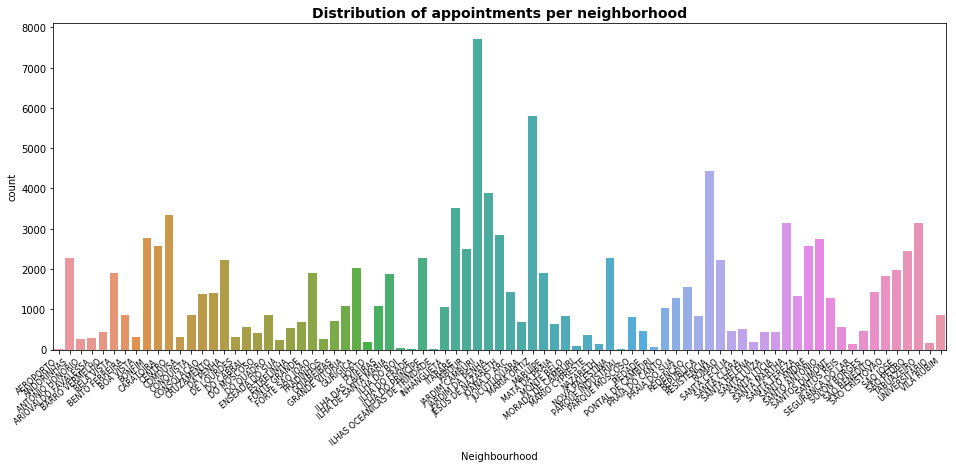

In [105]:
## 绘制不同区域预约人数分布图
plt.figure(figsize=(16,6))
ax = sns.countplot(x='Neighbourhood', data=df, order=neighborhood)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=8)
plt.title('Distribution of appointments per neighborhood', fontsize=14, fontweight='bold')
plt.show()

In [106]:
## 生成一张只含区域名称和就诊与未按约就诊人数
neighbors_I = df.groupby(by='Neighbourhood').No_show.value_counts().sort_index()

neighbors_I

Neighbourhood        No_show
AEROPORTO            No            7
                     Yes           1
ANDORINHAS           No         1741
                     Yes         521
ANTÔNIO HONÓRIO      No          221
                     Yes          50
ARIOVALDO FAVALESSA  No          220
                     Yes          62
BARRO VERMELHO       No          332
                     Yes          91
BELA VISTA           No         1523
                     Yes         384
BENTO FERREIRA       No          665
                     Yes         193
BOA VISTA            No          254
                     Yes          58
BONFIM               No         2223
                     Yes         550
CARATOÍRA            No         1974
                     Yes         591
CENTRO               No         2631
                     Yes         703
COMDUSA              No          254
                     Yes          56
CONQUISTA            No          689
                     Yes         160
CONSOLAÇÃ

In [107]:
def get_total(dataframe):
    # 返回每个属性的总和
    return dataframe.sum(axis=1)

In [108]:

neighbors_I = neighbors_I.unstack() 
neighbors_I.fillna(value=0, inplace=True)  #将NaN的值替换为0
print(neighbors_I.head(3))

No_show              No    Yes
Neighbourhood                 
AEROPORTO           7.0    1.0
ANDORINHAS       1741.0  521.0
ANTÔNIO HONÓRIO   221.0   50.0


In [109]:
def df_row_normalize(dataframe):
    # 规范化每行格式，返回每行总和
    return dataframe.div(dataframe.sum(axis=1), axis=0)

In [110]:
normalNeighbor = df_row_normalize(neighbors_I)
print(normalNeighbor.head(3))

No_show                No       Yes
Neighbourhood                      
AEROPORTO        0.875000  0.125000
ANDORINHAS       0.769673  0.230327
ANTÔNIO HONÓRIO  0.815498  0.184502


In [111]:
## 添加一列总和
neighbors_I['Total'] = get_total(neighbors_I)
normalNeighbor['Total'] = get_total(normalNeighbor)

In [112]:
#重置neighbors_I的index
neighbors_I.reset_index(inplace=True)  
normalNeighbor.reset_index(inplace=True)

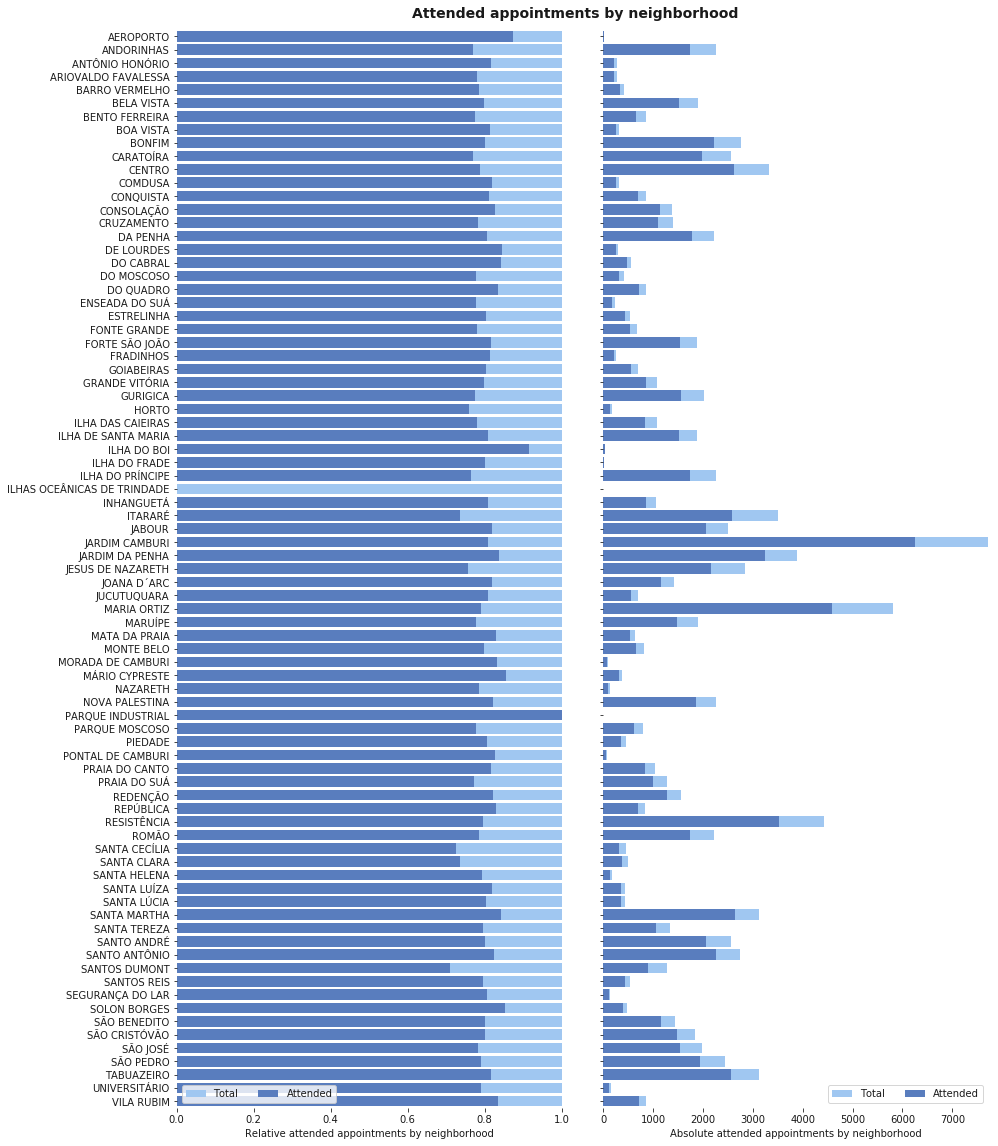

In [113]:
## 初始化
fig2, (ax1, ax2) = plt.subplots(1,2, figsize=(12,16), sharey=False)
fig2.tight_layout() 
fig2.subplots_adjust(top=0.96)  

## 不同区域的失约人数
#总预约
sns.set_color_codes("pastel")
sns.barplot(x="Total", y="Neighbourhood", data=normalNeighbor, label="Total", color="b", ax=ax1)
#就诊人数
sns.set_color_codes("muted")
sns.barplot(x="No", y="Neighbourhood", data=normalNeighbor, label="Attended", color="b", ax=ax1)
## 添加显示图标
ax1.legend(ncol=2, loc="lower left", frameon=True)
ax1.set(xlim=(0, 1), ylabel="", xlabel="Relative attended appointments by neighborhood")
sns.despine(left=True, bottom=True,ax=ax1)


sns.set_color_codes("pastel")
sns.barplot(x="Total", y="Neighbourhood", data=neighbors_I, label="Total", color="b",ax=ax2)
#就诊人数
sns.set_color_codes("muted")
sns.barplot(x="No", y="Neighbourhood", data=neighbors_I, label="Attended", color="b", ax=ax2)
## 添加显示图标
ax2.legend(ncol=2, loc="lower right", frameon=True)
ax2.set(xlim=(0, 7720), ylabel="", xlabel="Absolute attended appointments by neighborhood")  #The xlim value comes from the maximum value in the dataset.
ax2.set_yticklabels([''])
sns.despine(left=True, bottom=True, ax=ax2)

plt.suptitle('Attended appointments by neighborhood', fontsize=14, fontweight='bold')
plt.show()

### 分析
>通过上图可以看出预约人数较少和较多的城市的预约未就诊概率相对中等预约人数的城市较小，造成这样的结果可能是由于小城市预约人数本身就少，导致预约未就诊的几率变小，大城市预约人数较多，反映了就诊可能相对困难，医疗设备相对看病人数较少，导致预约之后的就诊率变大

### 不同地区预约未就诊的时长是否与地区存在某种关系
>该分析的主要目的是检查在所有考虑过的地理位置上等待时间越长，不显示率是否增加。为了达到这个目的，我们将使用一个热图，它依次是一个数组，其中列代表一个属性，而行代表另一个属性。每个单元格的值表示这些属性之间的相关性，为了便于查看，将转换为颜色图9。在我们的例子中，列表示等待的时间类别，而行代表社区。每个单元格的值（或颜色）表示未显示约会的百分比。

In [114]:
## 去掉ILHAS OCEÂNICAS DE TRINDADE区域，这个区域没有预约记录
df.drop(df[df['Neighbourhood'] == 'ILHAS OCEÂNICAS DE TRINDADE'].index, inplace=True)
neighbors_II = df.groupby(by=['Neighbourhood','No_show']).WaitingCategories.value_counts().sort_index()


In [115]:
##重新计算
neighborhood = df.Neighbourhood.unique()
neighborhood.sort()

In [116]:
## 整理数据集
neighbors_II = neighbors_II.unstack(1).unstack() 
neighbors_II.fillna(value=0, inplace=True)  
neighbors_II = df_row_normalize(neighbors_II)  
neighbors_II = neighbors_II['Yes']  
neighbors_II = (neighbors_II*100).astype('int64')
neighbors_II = neighbors_II.reindex(columns=['Same day: 0', 'Short: 1-3', 'Week: 4-7', 'Fortnight: 8-15', 'Month: 16-30', 'Quarter: 31-90', 'Semester: 91-180'])

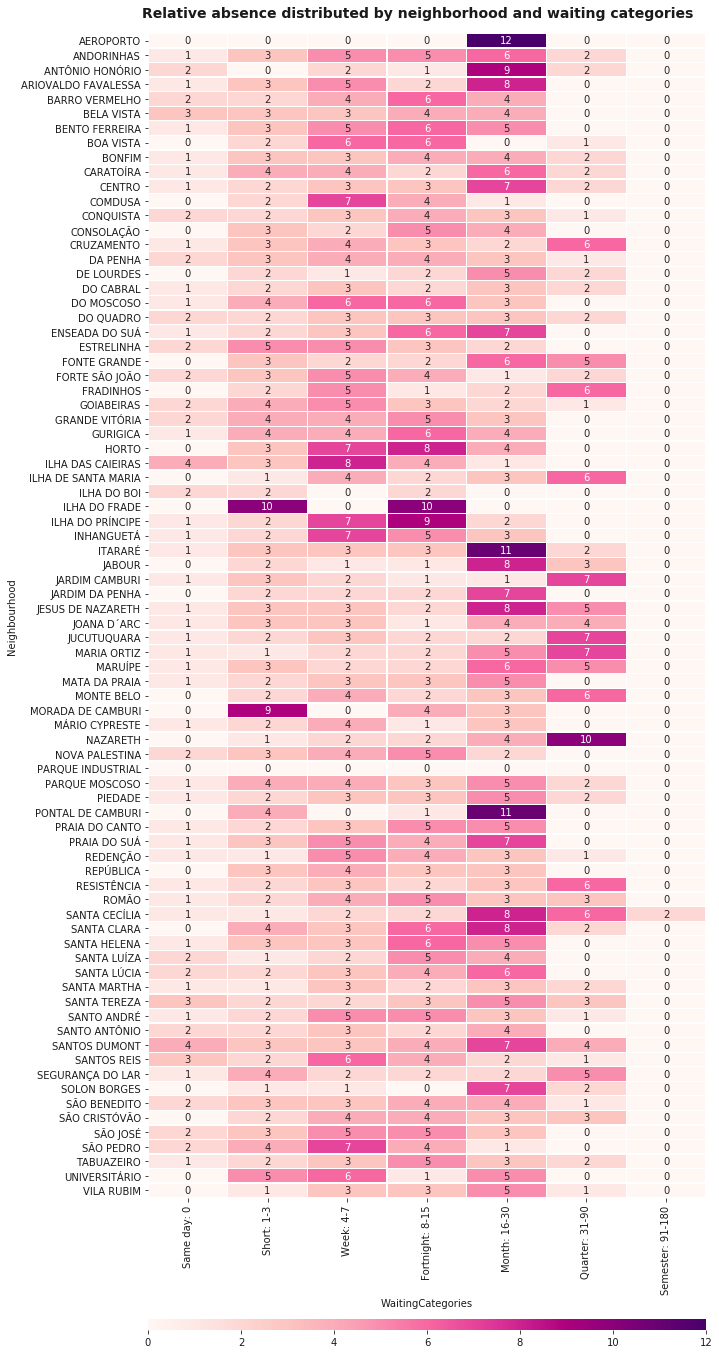

In [117]:
# 绘制不同地区预约未就诊的时长关系的热力图
fig3, ax = plt.subplots(figsize=(10, 25))
fig3.subplots_adjust(top=.965)
plt.suptitle('Relative absence distributed by neighborhood and waiting categories', fontsize=14, fontweight='bold')

cbar_kws = {'orientation':"horizontal", 'pad':0.08, 'aspect':50}
sns.heatmap(neighbors_II, annot=True, fmt='d', linewidths=.3, ax=ax, cmap='RdPu', cbar_kws=cbar_kws);

### 分析
>从热图中可以看到，一般情况下，随着等待时间的延长，大多数社区的等待时间会延长，而对每个地方的等待时间也会有所不同。一些社区甚至在短时间内都有较高的no-showing概率（如Ilha do Frade和Morada de Camburi）

<a id='quest4'></a>
### 4 、病历登记各项记录对失约情况影响

In [118]:
## 提取登记表中给出的相关信息
patients = df[['Gender','Age','Scholarship','Hipertension','Diabetes',
                    'Alcoholism','Handcap','WaitingCategories','SMS_received','No_show']]

In [119]:

patients.groupby(by=['No_show','WaitingCategories']).describe()

Age                                          \
                             count       mean        std  min    25%   50%   
No_show WaitingCategories                                                    
No      Same day: 0        36771.0  34.746675  23.275772 -1.0  15.00  34.0   
        Short: 1-3         11316.0  43.441322  22.996905  0.0  25.00  47.0   
        Week: 4-7          13097.0  40.951057  22.738829  0.0  22.00  43.0   
        Fortnight: 8-15     9362.0  36.772805  22.674522  0.0  18.00  36.0   
        Month: 16-30       10709.0  37.680456  23.145006  0.0  18.00  38.0   
        Quarter: 31-90      6792.0  39.727326  23.501633  0.0  20.00  42.0   
        Semester: 91-180     161.0  63.248447  24.794160  0.0  52.00  71.0   
Yes     Same day: 0         1792.0  28.392299  21.207981  0.0  12.00  21.0   
        Short: 1-3          3359.0  39.450729  22.604173  0.0  20.00  40.0   
        Week: 4-7           4413.0  36.433265  21.641937  0.0  20.00  35.0   
        Fortnight: 8-15     4166.0  32.448392  21.414294  0.0  16.00  30.0   
        Month: 16-30        5157.0  33.036843  21.210556  0.0  16.00  31.0   
        Quarter: 31-90      3369.0  33.519442  22.396125  0.0  14.00  32.0   
        Semester: 91-180      56.0  53.714286  27.043207  0.0  41.75  59.5   

                                        Alcoholism           ...   \
                             75%    max      count      mean ...    
No_show WaitingCategories                                    ...    
No      Same day: 0        53.00  115.0    36771.0  0.040304 ...    
        Short: 1-3         61.00  102.0    11316.0  0.025893 ...    
        Week: 4-7          59.00   97.0    13097.0  0.027564 ...    
        Fortnight: 8-15    54.00  115.0     9362.0  0.024033 ...    
        Month: 16-30       56.00  100.0    10709.0  0.021010 ...    
        Quarter: 31-90     58.00   98.0     6792.0  0.014134 ...    
        Semester: 91-180   82.00   94.0      161.0  0.006211 ...    
Yes     Same day: 0        44.00   97.0     1792.0  0.031250 ...    
        Short: 1-3         57.00  115.0     3359.0  0.035725 ...    
        Week: 4-7          53.00   95.0     4413.0  0.039882 ...    
        Fortnight: 8-15    48.00   98.0     4166.0  0.029045 ...    
        Month: 16-30       48.00   95.0     5157.0  0.024627 ...    
        Quarter: 31-90     51.00  115.0     3369.0  0.022262 ...    
        Semester: 91-180   76.25   95.0       56.0  0.035714 ...    

                          SMS_received      Scholarship                      \
                                   75%  max       count      mean       std   
No_show WaitingCategories                                                     
No      Same day: 0                0.0  0.0     36771.0  0.107286  0.309480   
        Short: 1-3                 0.0  1.0     11316.0  0.076264  0.265431   
        Week: 4-7                  1.0  1.0     13097.0  0.086585  0.281236   
        Fortnight: 8-15            1.0  1.0      9362.0  0.104251  0.305602   
        Month: 16-30               1.0  1.0     10709.0  0.090018  0.286221   
        Quarter: 31-90             1.0  1.0      6792.0  0.057715  0.233221   
        Semester: 91-180           1.0  1.0       161.0  0.055901  0.230447   
Yes     Same day: 0                0.0  0.0      1792.0  0.136719  0.343646   
        Short: 1-3                 0.0  1.0      3359.0  0.095862  0.294446   
        Week: 4-7                  1.0  1.0      4413.0  0.119420  0.324319   
        Fortnight: 8-15            1.0  1.0      4166.0  0.140663  0.347715   
        Month: 16-30               1.0  1.0      5157.0  0.115765  0.319974   
        Quarter: 31-90             1.0  1.0      3369.0  0.087860  0.283133   
        Semester: 91-180           1.0  1.0        56.0  0.089286  0.287736   

                                                    
                           min  25%  50%  75%  max  
No_show WaitingCategories                           
No      Same day: 0        

In [120]:
patients_sum = patients.groupby(by=['No_show','WaitingCategories']).sum()
patients_mean = patients.groupby(by=['No_show','WaitingCategories']).mean()


In [121]:
## 调整age属性，使其具有平均值而不是总和值：
patients = patients_sum.copy()
patients['Age'] = patients_mean['Age']

In [122]:
## 规范数据
patients = df_column_normalize(patients, percent=True)

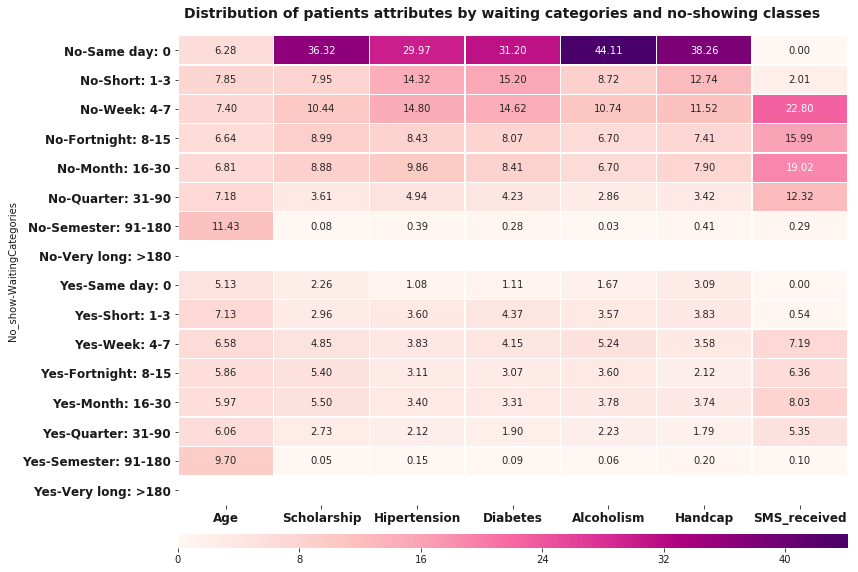

In [123]:
# 绘制热力图
fig4, ax = plt.subplots(figsize=(12, 10))
fig4.subplots_adjust(top=.94)
plt.suptitle('Distribution of patients attributes by waiting categories and no-showing classes', fontsize=14, fontweight='bold')

ax.set_yticklabels(ax.get_yticklabels(), ha="right", fontsize=12, weight='bold')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, weight='bold')

cbar_kws = {'orientation':"horizontal", 'pad':0.05, 'aspect':50}
sns.heatmap(patients, annot=True, fmt='.2f', linewidths=.3, ax=ax, cmap='RdPu', cbar_kws=cbar_kws);

      从热图和描述性统计数据可以得出以下结论：参加预约的病人一般都比那些没有预约的病人年龄大。大多数参加预约的病人在同一天接受了scholarship ，并表现出了hipertension、diabetes, alcoholism,和 handicap。这些数据可能表明这些患者（i）可能无法访问调度系统;或者（ii）可能需要更多的急救护理。高血压和糖尿病患者在医疗预约方面次数更多。大多数SMS_recieved治疗的患者（70%）已经预约了一周到一季度的预约。

<a id='conclusions'></a>
## 结论
>通过对未前往就诊的挂号预约的数据集的十万条数据进行分析，可以得出约有20.2%的患者没有按约就诊。通过这种方式目的是为了让人们对这个失约的可能原因有所了解。但是，在提供的数据和应用的方法中，不可能用统计有效性和因果关系来确认。另一方面，通过这一分析获得的结论，可以直接对这个问题进行深入的研究，从而验证失约的原因，并找到解决这些问题的方法。


In [124]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

4294967295